# Import libraries 

In [ ]:
import pandas as pd
import psycopg2
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans , AgglomerativeClustering 
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
import seaborn as sns


# Data preparation

## Download the data 

In [ ]:

sector_continent_tickers = {
  
    "Energy": {
        "XOM": "North America", "CVX": "North America", "BP": "Europe", "SHEL": "Europe",
        "ENI.MI": "Europe", "OXY": "North America", "TTE.PA": "Europe", "LNG": "North America",
        "EQT": "North America", "PBR": "South America", "SLB": "North America", "HAL": "North America",
        "BKR": "North America", "FTI": "North America", "VLO": "North America", "PSX": "North America",
        "COP": "North America", "DVN": "North America", "MPC": "North America", "APA": "North America"
    },
    "Defense": {
        "LMT": "North America", "NOC": "North America", "RTX": "North America", "BA": "North America",
        "GD": "North America", "TXT": "North America", "HII": "North America", "AIR.PA": "Europe",
        "HEI": "North America", "LDOS": "North America", "SAIC": "North America", "KTOS": "North America",
        "TDG": "North America", "AVAV": "North America", "MRCY": "North America"
    },
    "Commodities & Agriculture": {
        "RIO": "Australia", "BHP": "Australia", "VALE": "South America", "FCX": "North America",
        "NEM": "North America", "GLEN.L": "Europe", "MT": "Europe", "SCCO": "North America",
        "TECK": "North America", "CLF": "North America", "AA": "North America",
        "MOS": "North America", "NTR": "North America", "CF": "North America", "BG": "North America",
        "ADM": "North America", "FMC": "North America", "CTVA": "North America",
        "IPI": "North America"
    },
    "Technology": {
        "AAPL": "North America", "MSFT": "North America", "GOOGL": "North America", "AMZN": "North America",
        "META": "North America", "NVDA": "North America", "TSLA": "North America", "ORCL": "North America",
        "IBM": "North America", "CRM": "North America", "ADBE": "North America", "INTC": "North America",
        "AMD": "North America", "AVGO": "North America", "QCOM": "North America", "MU": "North America",
        "CSCO": "North America", "SNOW": "North America", "PYPL": "North America", "PANW": "North America",
        "FTNT": "North America", "CRWD": "North America", "ZS": "North America", "OKTA": "North America",
        "CHKP": "Europe"
    },
    "Finance": {
        "JPM": "North America", "MS": "North America", "C": "North America", "GS": "North America",
        "BAC": "North America", "WFC": "North America", "DB": "Europe", "BCS": "Europe",
        "GLE.PA": "Europe", "HSBC": "Europe", "UBS": "Europe", "SCHW": "North America",
        "BLK": "North America", "TROW": "North America", "ICE": "North America", "CME": "North America",
        "AXP": "North America", "SPGI": "North America", "MA": "North America", "V": "North America"
    }


}

# Create a map of tickers to sectors and continents
ticker_sectors = {ticker: sector for sector, tickers in sector_continent_tickers.items() for ticker, _ in tickers.items()}
ticker_continents = {ticker: continent for tickers in sector_continent_tickers.values() for ticker, continent in tickers.items()}

tickers = list(ticker_sectors.keys())  # list of tickers
start_date = "2022-02-01"
end_date = "2022-05-01"

data_list = []

#Iteration over the tickers calculating the daily return

data_list = []
shift_values = [0, 1, 3]

for ticker in tickers:
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = [col[0] for col in stock_data.columns]  #Maintain only 'Close', 'High' etc.
    print(stock_data.columns)
    stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

    # Compute the daily return 
    stock_data['return_daily'] = stock_data['Close'].pct_change() * 100  

    for shift in shift_values:
        shift_close = stock_data["Close"].shift(shift)
        shift_high = stock_data["High"].shift(shift)
        shift_low = stock_data["Low"].shift(shift)
        shift_open = stock_data["Open"].shift(shift)
        shift_volume = stock_data["Volume"].shift(shift)
        shift_daily_return = stock_data['return_daily'].shift(shift)

      # Append the data to the list
        data_list.extend(zip(
            [ticker] * len(stock_data), 
            [ticker_sectors[ticker]] * len(stock_data),  
            [ticker_continents[ticker]] * len(stock_data),  
            stock_data.index,  # Data
            shift_close, shift_high, shift_low, shift_open, shift_volume, shift_daily_return,  
            [shift] * len(stock_data)  
        ))

#Create and save the DataFrame
df = pd.DataFrame(data_list, columns=["ticker", "sector", "continent", "date", "close_price", "high_price", "low_price", "open_price", "volume", "daily_return", "shift_type"])
df.to_csv("stock_data_project_100.csv")

df.head()



'\nsector_continent_tickers = {\n  \n    "Energy": {\n        "XOM": "North America", "CVX": "North America", "BP": "Europe", "SHEL": "Europe",\n        "ENI.MI": "Europe", "OXY": "North America", "TTE.PA": "Europe", "LNG": "North America",\n        "EQT": "North America", "PBR": "South America", "SLB": "North America", "HAL": "North America",\n        "BKR": "North America", "FTI": "North America", "VLO": "North America", "PSX": "North America",\n        "COP": "North America", "DVN": "North America", "MPC": "North America", "APA": "North America"\n    },\n    "Defense": {\n        "LMT": "North America", "NOC": "North America", "RTX": "North America", "BA": "North America",\n        "GD": "North America", "TXT": "North America", "HII": "North America", "AIR.PA": "Europe",\n        "HEI": "North America", "LDOS": "North America", "SAIC": "North America", "KTOS": "North America",\n        "TDG": "North America", "AVAV": "North America", "MRCY": "North America"\n    },\n    "Commodities

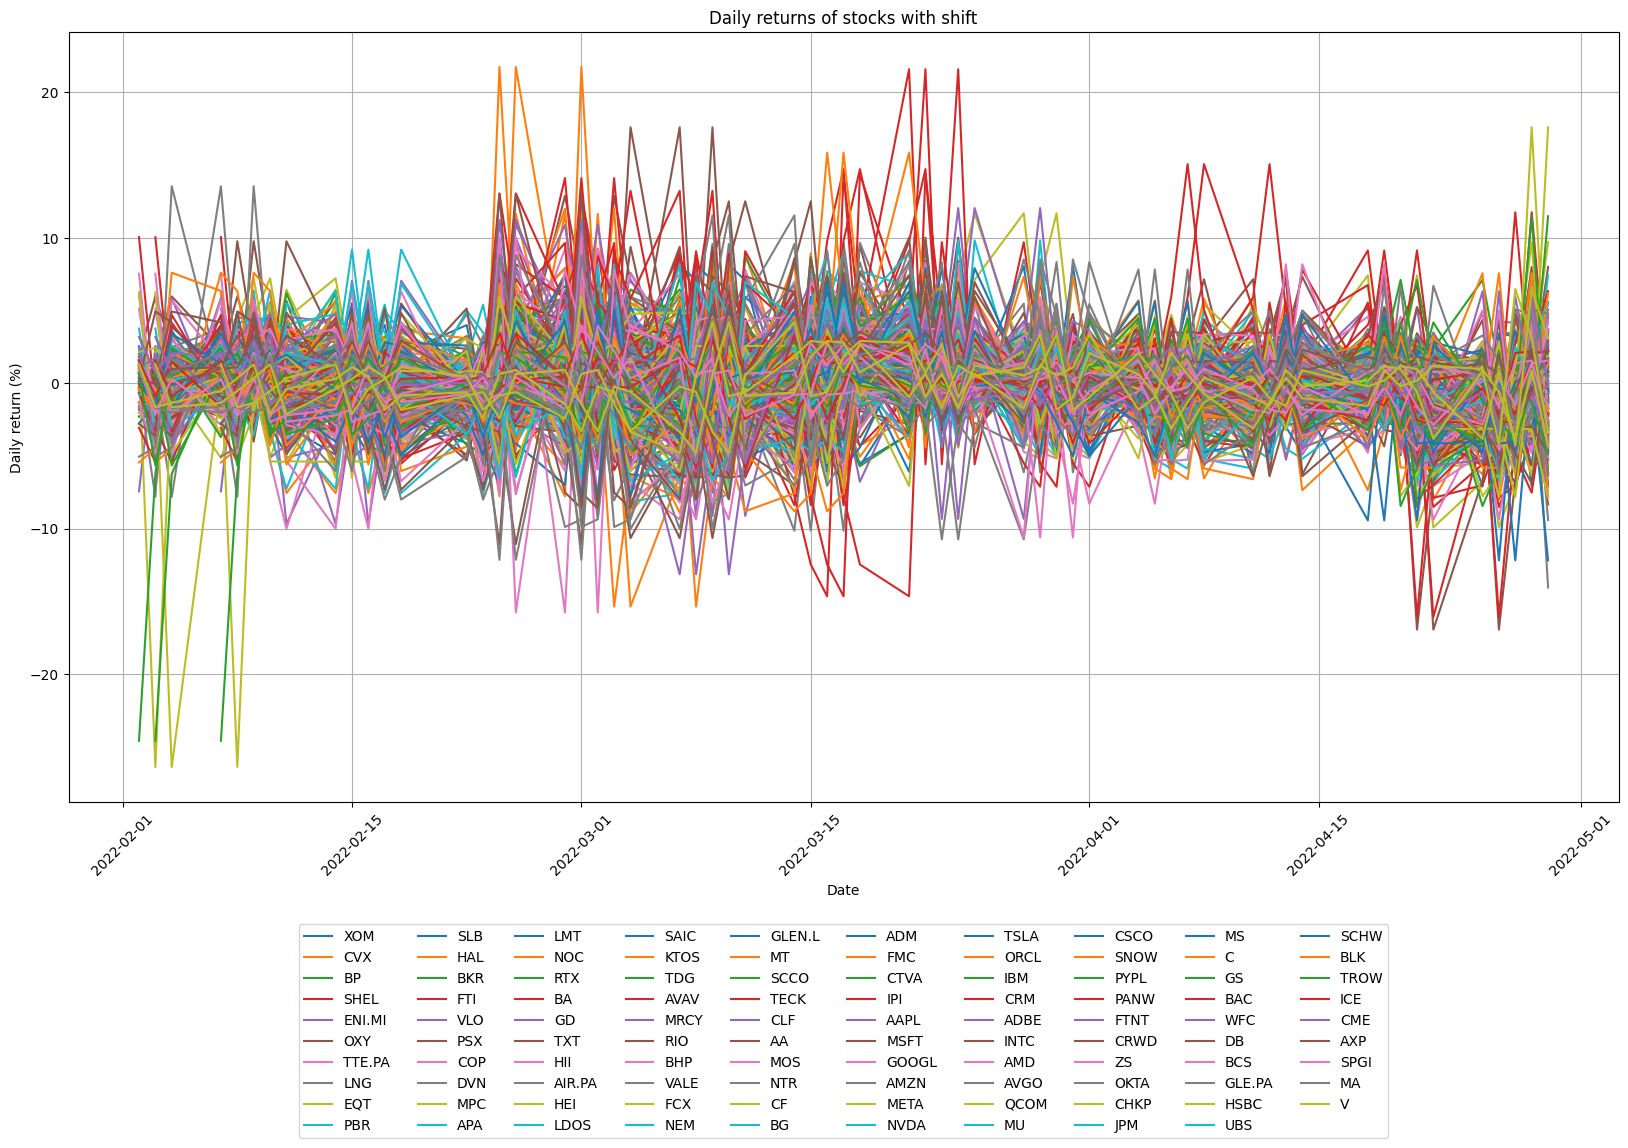

,Unnamed: 0,ticker,sector,continent,close_price,high_price,low_price,open_price,volume,daily_return,shift_type
date,,,,,,,,,,,
2022-02-01,0,XOM,Energy,North America,72.054680,72.660856,67.989732,68.150191,61033100.0,NaN,0
2022-02-02,1,XOM,Energy,North America,71.867462,72.036830,70.557052,71.368254,30299300.0,-0.259827,0
2022-02-03,2,XOM,Energy,North America,71.029503,71.591104,70.441153,71.394987,28529400.0,-1.165979,0
2022-02-04,3,XOM,Energy,North America,72.571701,73.570104,72.090326,72.090326,32197500.0,2.171208,0
2022-02-07,4,XOM,Energy,North America,73.445312,74.060405,71.885302,72.331019,34949200.0,1.203791,0


In [3]:
# Load the dataframe 
df = pd.read_csv("stock_data_project_100.csv", index_col="date", parse_dates=True)

# Plot the daily returns of each stock
plt.figure(figsize=(20, 10)) 
for ticker in df['ticker'].unique():
  plt.plot(df[df['ticker'] == ticker]['daily_return'], label=ticker)

plt.xlabel("Date")
plt.ylabel("Daily return (%)")
plt.title("Daily returns of stocks with shift")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=10) 
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

df.head()

In [ ]:
#Create a pivot dataframe with the date as columns and daily return  as values
pivot_df = df.pivot_table(
    index=['ticker', 'sector', 'continent', 'shift_type'],
    columns='date',
    values='daily_return',
    aggfunc='first'
)
# Reset the multi-index to have a flat DataFrame
pivot_df.reset_index(inplace=True)
# Remove the name of the index 
pivot_df.columns.name = None  
# substitute the NaN values with 0
pivot_df.fillna(0, inplace=True)

# Export the pivot dataframe to a CSV file
pivot_df.to_csv("project_df.csv", index=False)

pivot_df.head()

,ticker,sector,continent,shift_type,2022-02-02 00:00:00,2022-02-03 00:00:00,2022-02-04 00:00:00,2022-02-07 00:00:00,2022-02-08 00:00:00,2022-02-09 00:00:00,...,2022-04-18 00:00:00,2022-04-19 00:00:00,2022-04-20 00:00:00,2022-04-21 00:00:00,2022-04-22 00:00:00,2022-04-25 00:00:00,2022-04-26 00:00:00,2022-04-27 00:00:00,2022-04-28 00:00:00,2022-04-29 00:00:00
0,AA,Commodities & Agriculture,North America,0,1.787849,5.961848,2.358945,-0.731874,9.756859,2.772636,...,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738,4.509493,0.757227,-3.857060
1,AA,Commodities & Agriculture,North America,1,0.000000,1.787849,5.961848,2.358945,-0.731874,9.756859,...,0.400363,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738,4.509493,0.757227
2,AA,Commodities & Agriculture,North America,3,0.000000,0.000000,0.000000,1.787849,5.961848,2.358945,...,0.884526,4.996386,0.400363,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738
3,AAPL,Technology,North America,0,0.704427,-1.671972,-0.167937,-0.423463,1.846678,0.829377,...,-0.133080,1.411512,-0.101540,-0.484365,-2.782123,0.673711,-3.732834,-0.146655,4.515557,-3.660472
4,AAPL,Technology,North America,1,0.000000,0.704427,-1.671972,-0.167937,-0.423463,1.846678,...,-2.998826,-0.133080,1.411512,-0.101540,-0.484365,-2.782123,0.673711,-3.732834,-0.146655,4.515557


In [5]:
#To remove the timezone info from the column names
df = pd.read_csv('project_df.csv')
df.columns = [col.split(" ")[0] if " " in col else col for col in df.columns] 
print(len(df.columns))
df

66


,ticker,sector,continent,shift_type,2022-02-02,2022-02-03,2022-02-04,2022-02-07,2022-02-08,2022-02-09,...,2022-04-18,2022-04-19,2022-04-20,2022-04-21,2022-04-22,2022-04-25,2022-04-26,2022-04-27,2022-04-28,2022-04-29
0,AA,Commodities & Agriculture,North America,0,1.787849,5.961848,2.358945,-0.731874,9.756859,2.772636,...,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738,4.509493,0.757227,-3.857060
1,AA,Commodities & Agriculture,North America,1,0.000000,1.787849,5.961848,2.358945,-0.731874,9.756859,...,0.400363,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738,4.509493,0.757227
2,AA,Commodities & Agriculture,North America,3,0.000000,0.000000,0.000000,1.787849,5.961848,2.358945,...,0.884526,4.996386,0.400363,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738
3,AAPL,Technology,North America,0,0.704427,-1.671972,-0.167937,-0.423463,1.846678,0.829377,...,-0.133080,1.411512,-0.101540,-0.484365,-2.782123,0.673711,-3.732834,-0.146655,4.515557,-3.660472
4,AAPL,Technology,North America,1,0.000000,0.704427,-1.671972,-0.167937,-0.423463,1.846678,...,-2.998826,-0.133080,1.411512,-0.101540,-0.484365,-2.782123,0.673711,-3.732834,-0.146655,4.515557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,XOM,Energy,North America,1,0.000000,-0.259827,-1.165979,2.171208,1.203791,-2.585268,...,1.174988,0.819766,-0.892155,0.227890,-1.057301,-2.183144,-3.371330,0.036479,2.855754,3.024566
293,XOM,Energy,North America,3,0.000000,0.000000,0.000000,-0.259827,-1.165979,2.171208,...,2.087075,1.413539,1.174988,0.819766,-0.892155,0.227890,-1.057301,-2.183144,-3.371330,0.036479
294,ZS,Technology,North America,0,-1.375003,-4.846600,5.697497,1.521354,2.962870,3.745711,...,-3.149363,2.334833,-3.094535,-4.618648,-2.364402,4.998301,-4.372894,-1.230043,4.312367,-5.079822
295,ZS,Technology,North America,1,0.000000,-1.375003,-4.846600,5.697497,1.521354,2.962870,...,-4.307093,-3.149363,2.334833,-3.094535,-4.618648,-2.364402,4.998301,-4.372894,-1.230043,4.312367


In [6]:
# Remove the first 3 numeric columns because they are not needed

# Define numeric_columns as the list of numeric columns in the DataFrame
numeric_columns = df.select_dtypes(include=['float64']).columns.tolist()

# Drop the first 3 numeric columns
df = df.drop(columns=numeric_columns[:3])  
print(df.columns)
df

Index(['ticker', 'sector', 'continent', 'shift_type', '2022-02-07',
       '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-14',
       '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-21',
       '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-28',
       '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-07',
       '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-14',
       '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21',
       '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-28',
       '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-04',
       '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-11',
       '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-18', '2022-04-19',
       '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-25', '2022-04-26',
       '2022-04-27', '2022-04-28', '2022-04-29'],
      dtype='object')


,ticker,sector,continent,shift_type,2022-02-07,2022-02-08,2022-02-09,2022-02-10,2022-02-11,2022-02-14,...,2022-04-18,2022-04-19,2022-04-20,2022-04-21,2022-04-22,2022-04-25,2022-04-26,2022-04-27,2022-04-28,2022-04-29
0,AA,Commodities & Agriculture,North America,0,-0.731874,9.756859,2.772636,-1.029068,3.301932,0.462484,...,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738,4.509493,0.757227,-3.857060
1,AA,Commodities & Agriculture,North America,1,2.358945,-0.731874,9.756859,2.772636,-1.029068,3.301932,...,0.400363,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738,4.509493,0.757227
2,AA,Commodities & Agriculture,North America,3,1.787849,5.961848,2.358945,-0.731874,9.756859,2.772636,...,0.884526,4.996386,0.400363,1.914110,-3.208517,0.404256,-16.944661,-6.689755,0.000000,-0.593738
3,AAPL,Technology,North America,0,-0.423463,1.846678,0.829377,-2.359894,-2.021839,0.142316,...,-0.133080,1.411512,-0.101540,-0.484365,-2.782123,0.673711,-3.732834,-0.146655,4.515557,-3.660472
4,AAPL,Technology,North America,1,-0.167937,-0.423463,1.846678,0.829377,-2.359894,-2.021839,...,-2.998826,-0.133080,1.411512,-0.101540,-0.484365,-2.782123,0.673711,-3.732834,-0.146655,4.515557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,XOM,Energy,North America,1,2.171208,1.203791,-2.585268,-0.478718,-0.962031,2.517897,...,1.174988,0.819766,-0.892155,0.227890,-1.057301,-2.183144,-3.371330,0.036479,2.855754,3.024566
293,XOM,Energy,North America,3,-0.259827,-1.165979,2.171208,1.203791,-2.585268,-0.478718,...,2.087075,1.413539,1.174988,0.819766,-0.892155,0.227890,-1.057301,-2.183144,-3.371330,0.036479
294,ZS,Technology,North America,0,1.521354,2.962870,3.745711,1.157201,-3.907077,0.523807,...,-3.149363,2.334833,-3.094535,-4.618648,-2.364402,4.998301,-4.372894,-1.230043,4.312367,-5.079822
295,ZS,Technology,North America,1,5.697497,1.521354,2.962870,3.745711,1.157201,-3.907077,...,-4.307093,-3.149363,2.334833,-3.094535,-4.618648,-2.364402,4.998301,-4.372894,-1.230043,4.312367


## Creation of the PostgreSQL database

In [ ]:
# Database connection
conn = psycopg2.connect(
    host="localhost",
    database="database_name",
    user="postgres",
    password="your password",
    port="5432"
)

In [8]:
# Create the table stock_return 

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS stock_return")

# Automatic creation of the date columns
date_columns = df.columns.difference(['ticker', 'sector', 'continent', 'shift_type'])
date_columns_str = ', '.join([f'"{date}" FLOAT' for date in date_columns]) 

# Query for creating the table
create_table_query = f"""
CREATE TABLE stock_return (
    id SERIAL PRIMARY KEY,
    ticker TEXT,
    sector TEXT,
    continent TEXT,
    shift_type INTEGER,
    {date_columns_str}
);
"""
cursor.execute(create_table_query)
conn.commit()  

# Creation of the automatic insert query
placeholders = ', '.join(['%s' for _ in date_columns])  # Placeholder for each date

insert_query = f"""
INSERT INTO stock_return (ticker, sector, continent, shift_type, {', '.join([f'"{date}"' for date in date_columns])})
VALUES (%s, %s, %s, %s, {placeholders});
"""

for i, row in df.iterrows():
    cursor.execute(insert_query, tuple(row)) 

conn.commit()

print("data inserted successfully!")
print("table created successfully!")


data inserted successfully!
table created successfully!


In [9]:
#Drop the column "2022-02-21" from the table stock_return because there are too many 0 values
query = """
ALTER TABLE stock_return
DROP COLUMN "2022-02-21"
"""

cursor = conn.cursor()
cursor.execute(query)
conn.commit()


# Clustering analysis without shift

## Data pre-processing

In [10]:
# Query to get the data from the database
query = """
SELECT *
FROM stock_return where shift_type = 0
"""

# Load the data into a DataFrame
df = pd.read_sql_query(query, conn)

# Add volatility column to better understand the data
df["volatility"] = df.iloc[:, 5:].std(axis=1).fillna(0)

# Map sector names to numeric labels
sector_to_numeric = {sector: idx for idx, sector in enumerate(df['sector'].unique())}
df['sector_numeric'] = df['sector'].map(sector_to_numeric)
y = df['sector_numeric']

# Map continent names to numeric labels
continent_to_numeric = {continent: idx for idx, continent in enumerate(df['continent'].unique())}
df['continent_numeric'] = df['continent'].map(continent_to_numeric)
y2 = df['continent_numeric']

X = df.iloc[:, 5:].drop(['sector_numeric','continent_numeric'], axis= 'columns')  
# normalize the data
scaler = MinMaxScaler()
print(X.columns)
X_scaled = scaler.fit_transform(X) 

# PCA to visualize the clusters
pca = PCA(n_components= 2)
df_pca = pca.fit_transform(X_scaled)


Index(['2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
       '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
       '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-28',
       '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-07',
       '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-14',
       '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21',
       '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-28',
       '2022-03-29', '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-04',
       '2022-04-05', '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-11',
       '2022-04-12', '2022-04-13', '2022-04-14', '2022-04-18', '2022-04-19',
       '2022-04-20', '2022-04-21', '2022-04-22', '2022-04-25', '2022-04-26',
       '2022-04-27', '2022-04-28', '2022-04-29', 'volatility'],
      dtype='object')


/var/folders/pq/dd_4ww1x5rgddfrx5q07qwx40000gn/T/ipykernel_963/447391052.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


## K Means clustering

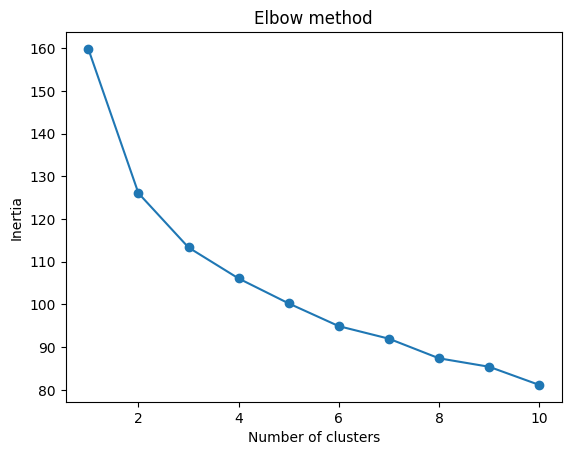

In [11]:
#Elbow method
inertia = []
for k in range(1, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()


{'Commodities & Agriculture': 'o', 'Technology': 's', 'Defense': 'D', 'Energy': '^', 'Finance': 'v'}


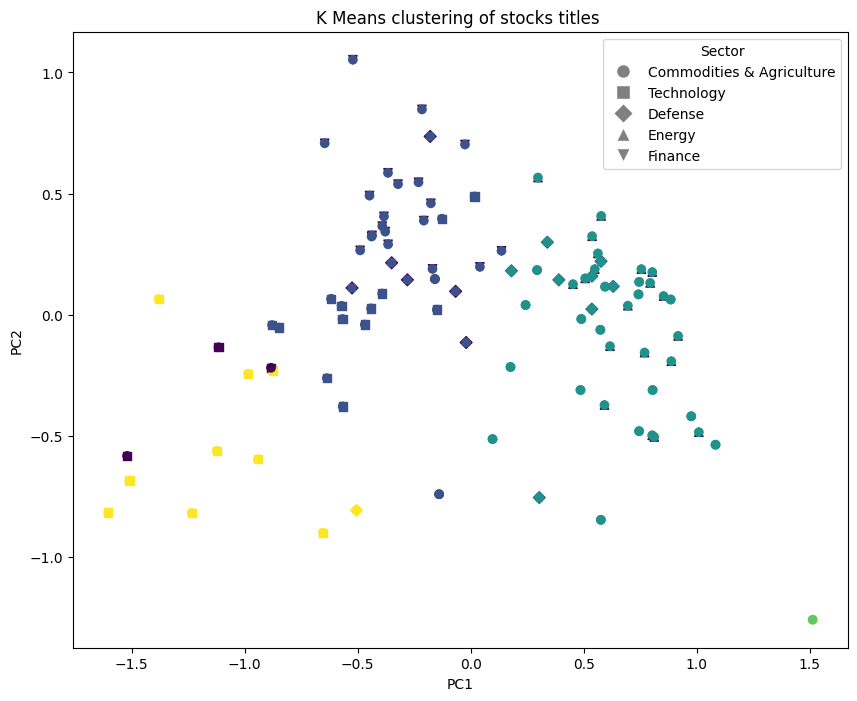

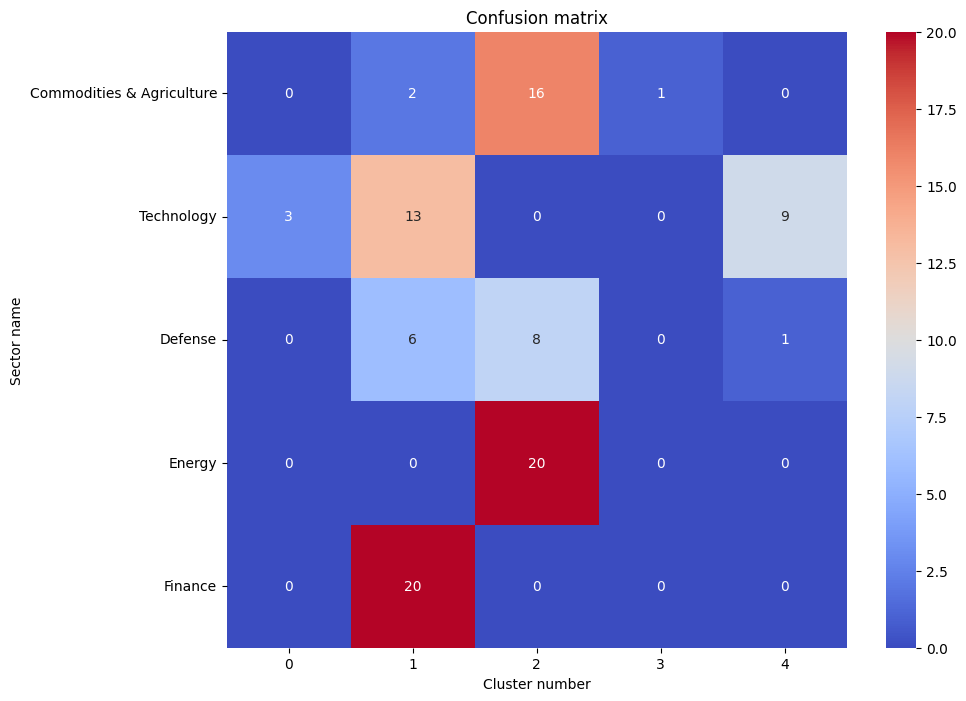

Silhouette score: 0.14954014665417137
Homogeneity: 0.39447112632243375
Completeness: 0.5676400502981185
V-Measure: 0.46547138299201524




In [55]:
number_of_clusters = 5
kmeans = KMeans(n_clusters= number_of_clusters)
kmeans.fit(X_scaled)
df['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 8))

# Create markers based on the sector
unique_sectors = df['sector'].unique()
markers = ['o', 's', 'D', '^', 'v']
sector_marker_map = {sector: markers[i % len(markers)] for i, sector in enumerate(unique_sectors)}
print(sector_marker_map)
for sector in unique_sectors:
    sector_indices = df['sector'] == sector
    plt.scatter(
        df_pca[sector_indices, 0],
        df_pca[sector_indices, 1],
        c=df['Cluster'][sector_indices],
        cmap='viridis',
        marker=sector_marker_map[sector],
        label=sector
    )

plt.legend(title="Sector")
scatter = plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df['Cluster'], cmap= 'viridis')  
plt.xlabel('PC1')
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker=sector_marker_map[sector], color='w', label=sector, markerfacecolor='gray', markersize=10)
        for sector in unique_sectors
    ],
    title="Sector",
    loc="upper right"
)
plt.ylabel('PC2')
plt.title('K Means clustering of stocks titles ')

# Check if stocks from the same sector are grouped together in clusters

# Visualize the confusion matrix as a heatmap
conf_matrix = confusion_matrix(df["sector_numeric"], df["Cluster"])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=range(number_of_clusters), yticklabels=sector_to_numeric.keys())
plt.title('Confusion matrix')
plt.xlabel('Cluster number')
plt.ylabel('Sector name')
plt.show()

# Performance index

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette score: {silhouette_avg}")

# Calculate homogeneity, completeness, and V-measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, df['Cluster'])

print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")
print("\n")



<Figure size 1000x800 with 0 Axes>

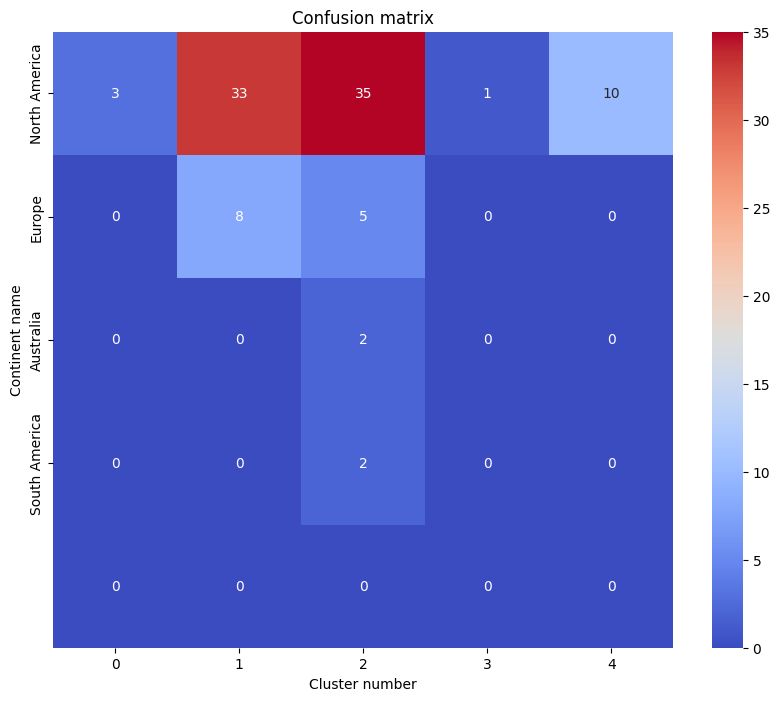

Homogeneity: 0.10383826880468736
Completeness: 0.054312686591726965
V-Measure: 0.07132091406820992




In [56]:
# K means for the continent 
plt.figure(figsize=(10, 8))

# Check if stocks from the same sector are grouped together in clusters

# Visualize the confusion matrix as a heatmap
conf_matrix = confusion_matrix(df["continent_numeric"], df["Cluster"])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=range(number_of_clusters), yticklabels=continent_to_numeric.keys())
plt.title('Confusion matrix')
plt.xlabel('Cluster number')
plt.ylabel('Continent name')
plt.show()

# Performance index

# Calculate homogeneity, completeness, and V-measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y2, df['Cluster'])

print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")
print("\n")



[[0.56582498 0.15122855 0.29405562 0.58159439 0.78087924 0.44682422
  0.21166674 0.59327978 0.56925746 0.54611574 0.44558989 0.78789771
  0.34743554 0.69118732 0.46007667 0.49876822 0.53651786 0.64578456
  0.42324994 0.67188941 0.61795154 0.17062308 0.46153449 0.62800266
  0.40256364 0.47000202 0.46216155 0.39808451 0.29277061 0.30860917
  0.3707571  0.61757287 0.26381689 0.40573295 0.40465417 0.46274324
  0.68240556 0.69149426 0.55872705 0.28362708 0.57409736 0.53681383
  0.20587073 0.64465742 0.33082301 0.51111274 0.42869377 0.65922786
  0.61944059 0.30556771 0.52491407 0.67190856 0.50763065 0.21025539
  0.7701978  0.48083974 0.23199172 0.67296984 0.20603288]
 [0.39904543 0.38611012 0.51546725 0.40387902 0.37470458 0.77631189
  0.53426038 0.36793854 0.26665691 0.39405514 0.52927774 0.40805116
  0.57266748 0.61414199 0.51595285 0.44619847 0.41108537 0.5060885
  0.29912779 0.36095085 0.4795099  0.5963955  0.26568285 0.46005054
  0.37082476 0.78835503 0.63942672 0.29612868 0.56239204 0.

<Figure size 1600x600 with 0 Axes>

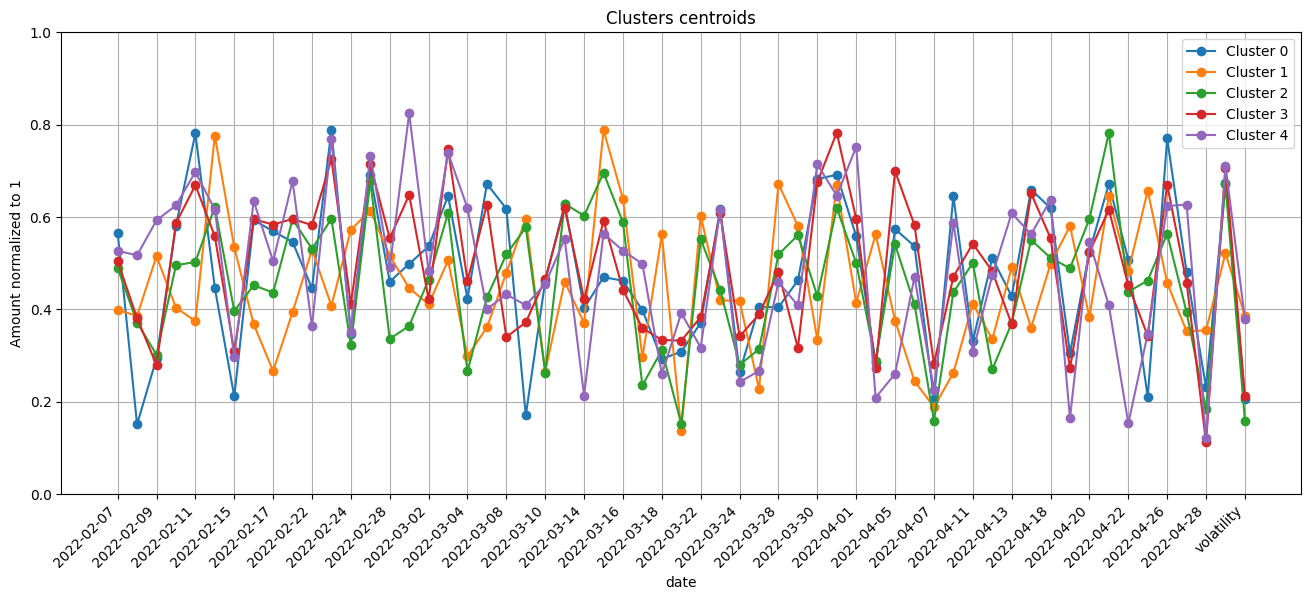

In [14]:
# Plot the clusters centroids
centroids = kmeans.cluster_centers_
print(centroids)

# plot the centers of the clusters
plt.figure(figsize=(16, 6))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))  
ax.plot(centroids.transpose(), 'o-')
ax.set_xlabel('date')
ax.set_ylabel('Amount normalized to 1')
plt.title('Clusters centroids')
ax.legend(['Cluster %d' % i for i in range(number_of_clusters)])
ax.set_xticks(range(len(X.columns)))  # Use the length of X.columns
ax.set_xticklabels(X.columns.tolist())  # Convert X.columns to a list for labels
plt.xticks(rotation=45, ha='right', ticks=np.arange(0, len(X.columns), step=2))

plt.grid()
plt.ylim([0, 1]);


## Agglomerative clustering

### Euclidean distance

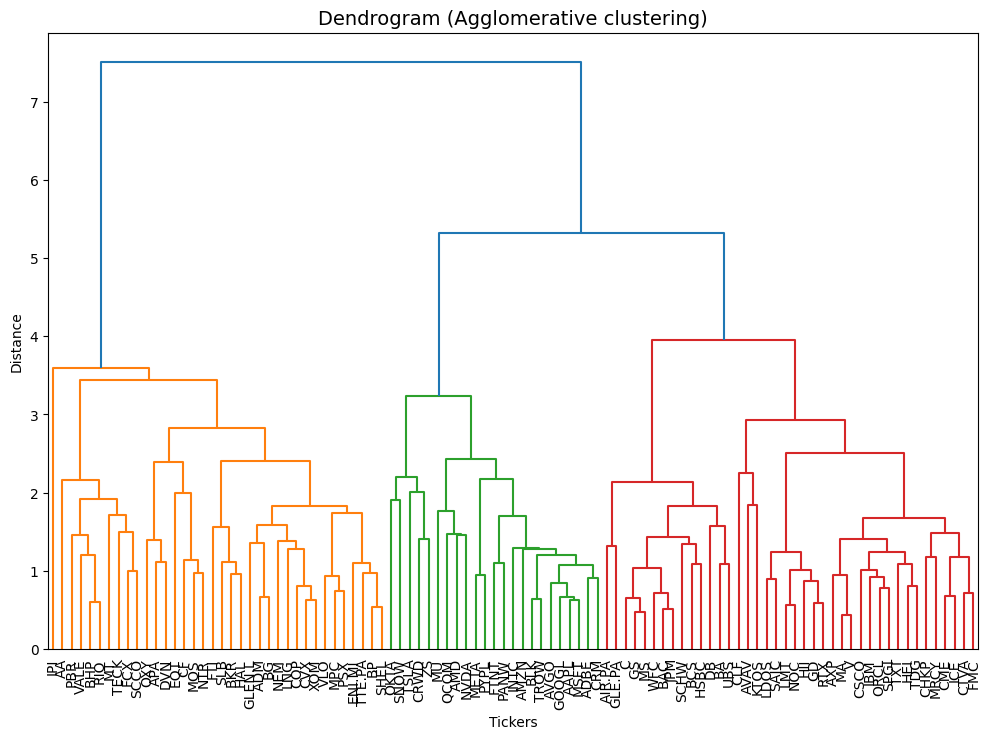

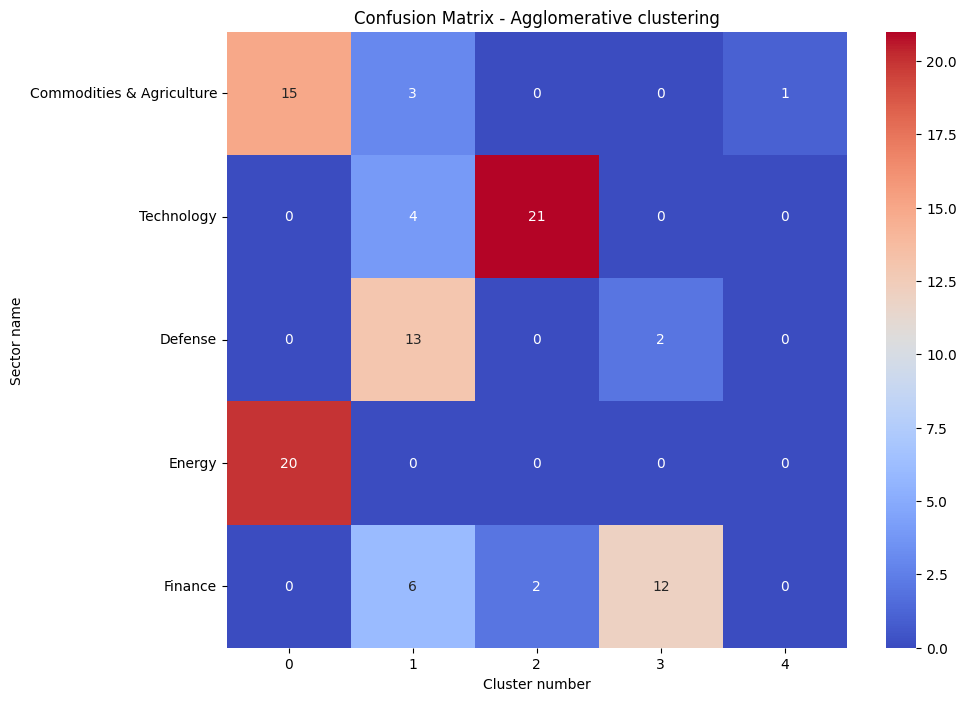

Homogeneity: 0.5684096281042906
Completeness: 0.6571582225193835
V-Measure: 0.6095705932198413
Silhouette score: 0.08685021867518734


In [19]:
number_of_clusters = 5
agg_clustering = AgglomerativeClustering(n_clusters= number_of_clusters, linkage='ward').fit(X_scaled)
df['Agglomerative_Cluster'] = agg_clustering.labels_

# Create the dendrogram
linkage_matrix = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df['ticker'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram (Agglomerative clustering)", fontsize=14)
plt.xlabel("Tickers")
plt.ylabel("Distance")
plt.show()


# Visualize the confusion matrix as a heatmap
conf_matrix = confusion_matrix(df["sector_numeric"], df["Agglomerative_Cluster"])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=range(number_of_clusters), yticklabels=sector_to_numeric.keys())
plt.title('Confusion Matrix - Agglomerative clustering')
plt.xlabel('Cluster number')
plt.ylabel('Sector name')
plt.show()



# Performance index

# Calculate homogeneity, completeness, and V-measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, df['Agglomerative_Cluster'])

print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

#Silhouette Score
silhouette_avg = silhouette_score(X_scaled, df['Agglomerative_Cluster'])
print(f"Silhouette score: {silhouette_avg}")

### Distance based on correlation

Silhouette score (Correlation-based): 0.223
Homogeneity: 0.23235506299883993
Completeness: 0.5038144602851704
V-Measure: 0.3180350094827946


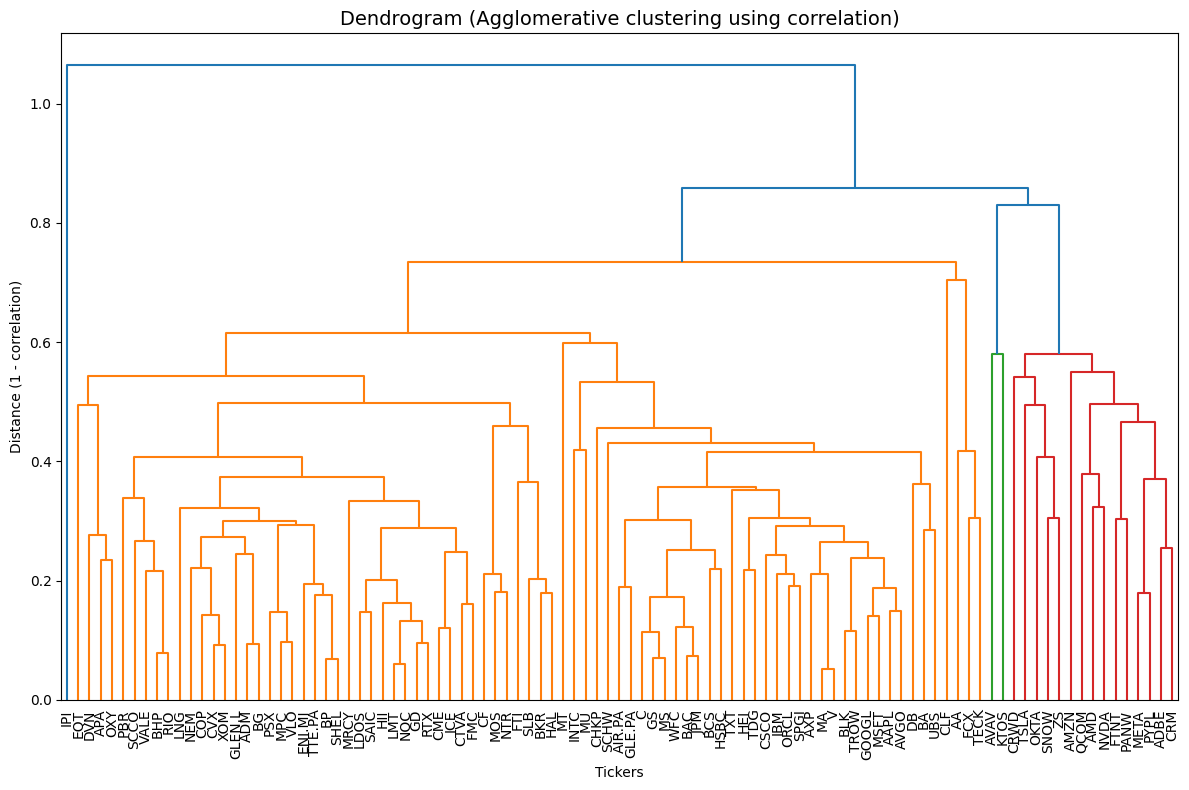

In [16]:
# Compute the distance matrix between the rows using correlation-based distance
correlation_matrix = np.corrcoef(X_scaled, rowvar=True)

# Convert the correlation matrix to a distance matrix
distance_matrix = 1 - correlation_matrix

# Condense the matrix for linkage (only the upper triangle is needed)
condensed_dist = squareform(distance_matrix, checks=False)

# Agglomerative clustering using average
linkage_matrix = linkage(condensed_dist, method='average')

# Use fcluster to obtain clusters from the linkage matrix since AgglomerativeClustering does not accept precomputed distance matrices
labels_correlation = fcluster(linkage_matrix, t=5, criterion='maxclust')

# Silhouette score 
silhouette_score_correlation = silhouette_score(distance_matrix, labels_correlation, metric='precomputed')
print(f"Silhouette score (Correlation-based): {silhouette_score_correlation:.3f}")

# homogeneity, completeness, v-measure 
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(y, labels_correlation)
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

# Dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df['ticker'].values, leaf_rotation=90, leaf_font_size=10)
plt.title("Dendrogram (Agglomerative clustering using correlation)", fontsize=14)
plt.xlabel("Tickers")
plt.ylabel("Distance (1 - correlation)")
plt.tight_layout()
plt.show()


## The influence of the ukraine invasion in the pattern of the stock titles

/var/folders/pq/dd_4ww1x5rgddfrx5q07qwx40000gn/T/ipykernel_963/3110443067.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster_pre_event', y='pre_event_mean', palette='viridis')


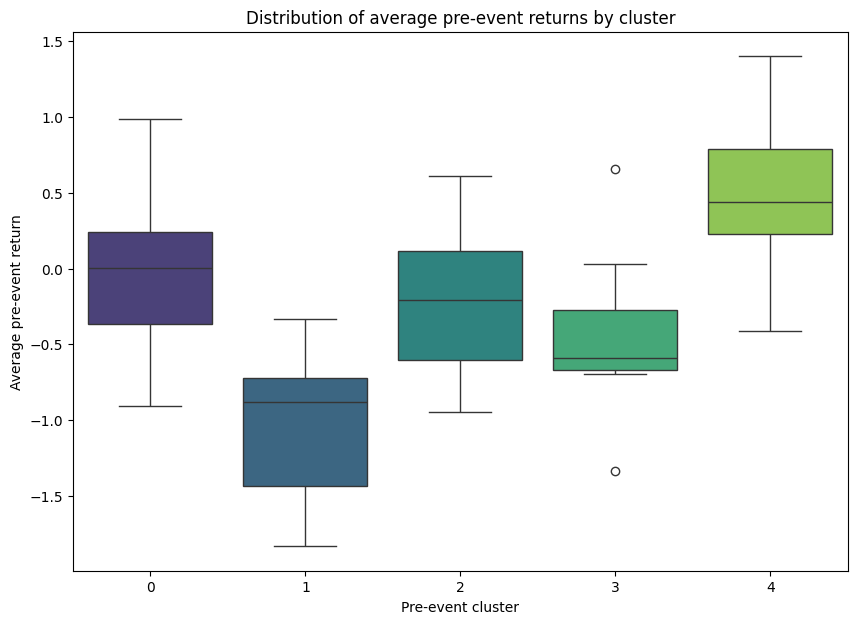

/var/folders/pq/dd_4ww1x5rgddfrx5q07qwx40000gn/T/ipykernel_963/3110443067.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster_post_event', y='post_event_mean', palette='viridis')


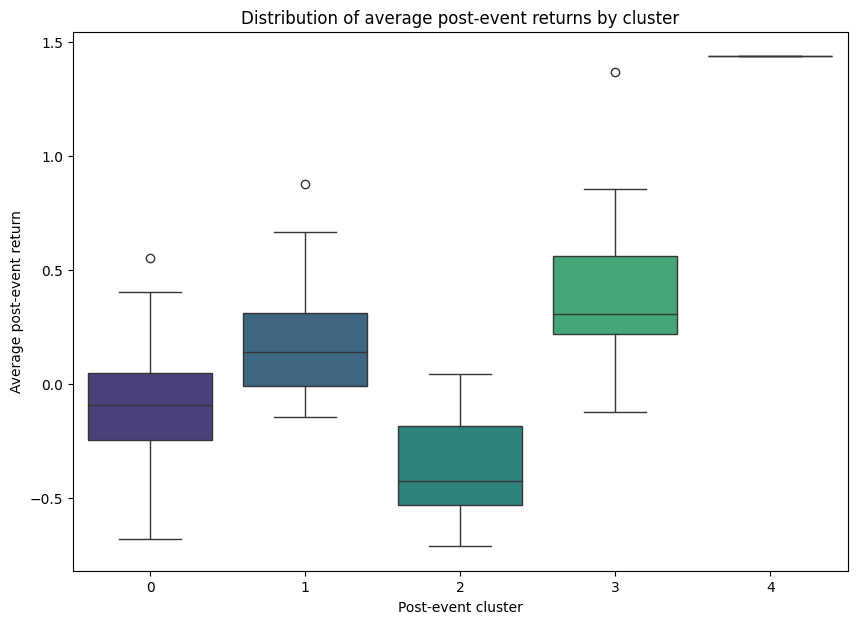

                       sector  Cluster_pre_event  pre_event_mean  \
0   Commodities & Agriculture                  0        0.363794   
1   Commodities & Agriculture                  2        0.310892   
2   Commodities & Agriculture                  3        0.030326   
3   Commodities & Agriculture                  4        0.548763   
4                     Defense                  0        0.086518   
5                     Defense                  1       -0.721981   
6                     Defense                  2        0.040624   
7                     Defense                  4        0.184069   
8                      Energy                  0       -0.117664   
9                      Energy                  2        0.190967   
10                    Finance                  0       -0.563342   
11                    Finance                  2       -0.480215   
12                 Technology                  1       -1.032259   
13                 Technology                  2

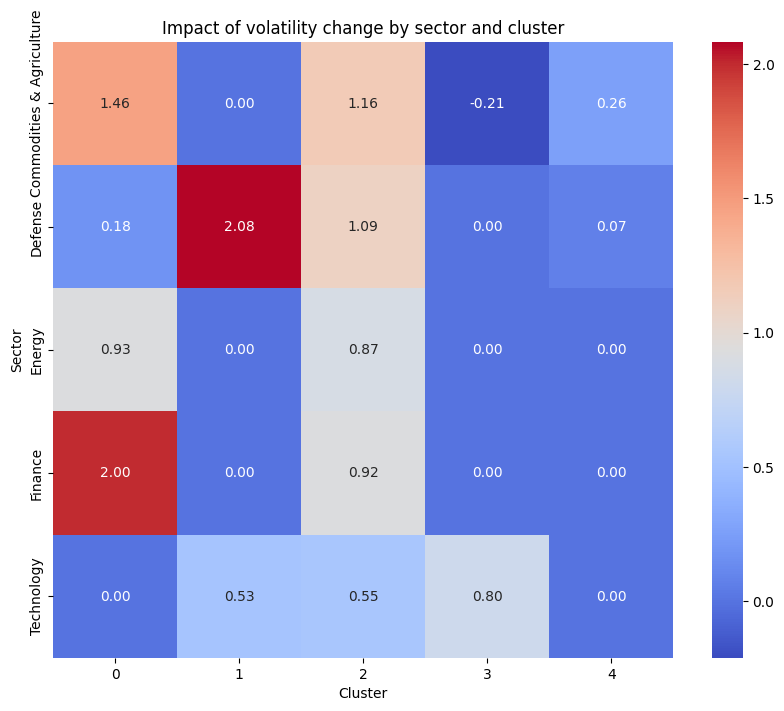

       continent  Cluster_pre_event  pre_event_mean  post_event_mean  \
0      Australia                  2        0.372508        -0.018299   
1         Europe                  0       -0.433960        -0.202677   
2         Europe                  2       -0.044342        -0.177743   
3         Europe                  4       -0.414476         0.028470   
4  North America                  0        0.039592         0.444586   
5  North America                  1       -1.008391        -0.003784   
6  North America                  2       -0.337910        -0.062329   
7  North America                  3       -0.450129        -0.130131   
8  North America                  4        0.668472         0.023340   
9  South America                  2        0.497839         0.023696   

   volatility_change  
0           0.979276  
1           1.578453  
2           1.458388  
3           0.000047  
4           0.847607  
5           0.645186  
6           0.810028  
7           0.658143  


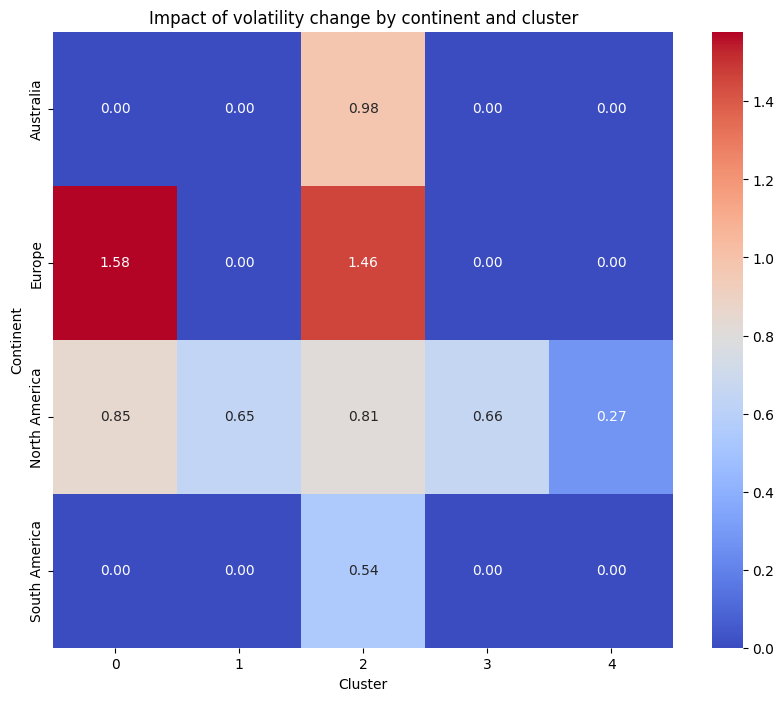

In [ ]:
# Filter the data based on a specific date such as the start of the ukraine war
date_columns = [col for col in X.columns if col.startswith('20')] #because there are some columns that are not dates 
event_date = '2022-02-24'

pre_event_columns = [col for col in date_columns if col < event_date]
post_event_columns = [col for col in date_columns if col >= event_date]

# Compute the mean and volatility for pre-event and post-event periods
df['pre_event_mean'] = df[pre_event_columns].mean(axis=1)
df['post_event_mean'] = df[post_event_columns].mean(axis=1)
df['pre_event_volatility'] = df[pre_event_columns].std(axis=1)
df['post_event_volatility'] = df[post_event_columns].std(axis=1)

# Pre-event agglomerative clustering
pre_event_data = df[pre_event_columns]
pre_event_scaled = scaler.fit_transform(pre_event_data)

agg_pre_event = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(pre_event_scaled)
df['Cluster_pre_event'] = agg_pre_event.labels_ 

# Visualize the distribution of the clusters pre-event with a boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='Cluster_pre_event', y='pre_event_mean', palette='viridis')
plt.title('Distribution of average pre-event returns by cluster')
plt.xlabel('Pre-event cluster')
plt.ylabel('Average pre-event return')
plt.show()

# Post-event agglomerative clustering
post_event_data = df[post_event_columns]
post_event_scaled = scaler.fit_transform(post_event_data)

agg_post_event = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(post_event_scaled)
df['Cluster_post_event'] = agg_post_event.labels_ 

# Visualize the distribution of the clusters post-event with a boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='Cluster_post_event', y='post_event_mean', palette='viridis')
plt.title('Distribution of average post-event returns by cluster')
plt.xlabel('Post-event cluster')
plt.ylabel('Average post-event return')
plt.show()

# Calculate the volatility change as the difference between post-event and pre-event volatility
df['volatility_change'] = df['post_event_volatility'] - df['pre_event_volatility']

# Sector analysis

sector_analysis = df.groupby(['sector', 'Cluster_pre_event'])[['pre_event_mean', 'post_event_mean', 'volatility_change']].mean().reset_index()
print(sector_analysis)

# Heatmap to visualize the impact by sector
pivot_table = sector_analysis.pivot(index='sector', columns='Cluster_pre_event', values='volatility_change').fillna(0)
print(pivot_table)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Impact of volatility change by sector and cluster')
plt.xlabel('Cluster')
plt.ylabel('Sector')
plt.show()

# Continent analysis

continent_analysis = df.groupby(['continent', 'Cluster_pre_event'])[['pre_event_mean', 'post_event_mean', 'volatility_change']].mean().reset_index() 
print(continent_analysis)

# Heatmap to visualize the impact by continent
pivot_table = continent_analysis.pivot(index='continent', columns='Cluster_pre_event', values='volatility_change').fillna(0)
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Impact of volatility change by continent and cluster')
plt.xlabel('Cluster')
plt.ylabel('Continent')
plt.show()


# Clustering analysis with shift

/var/folders/pq/dd_4ww1x5rgddfrx5q07qwx40000gn/T/ipykernel_963/1047400861.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  shift_df = pd.read_sql_query(query, conn)


Index(['id', 'ticker', 'sector', 'continent', 'shift_type', '2022-02-07',
       '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-14',
       '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-22',
       '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-28', '2022-03-01',
       '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-07', '2022-03-08',
       '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-14', '2022-03-15',
       '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-21', '2022-03-22',
       '2022-03-23', '2022-03-24', '2022-03-25', '2022-03-28', '2022-03-29',
       '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-04', '2022-04-05',
       '2022-04-06', '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12',
       '2022-04-13', '2022-04-14', '2022-04-18', '2022-04-19', '2022-04-20',
       '2022-04-21', '2022-04-22', '2022-04-25', '2022-04-26', '2022-04-27',
       '2022-04-28', '2022-04-29'],
      dtype='object')


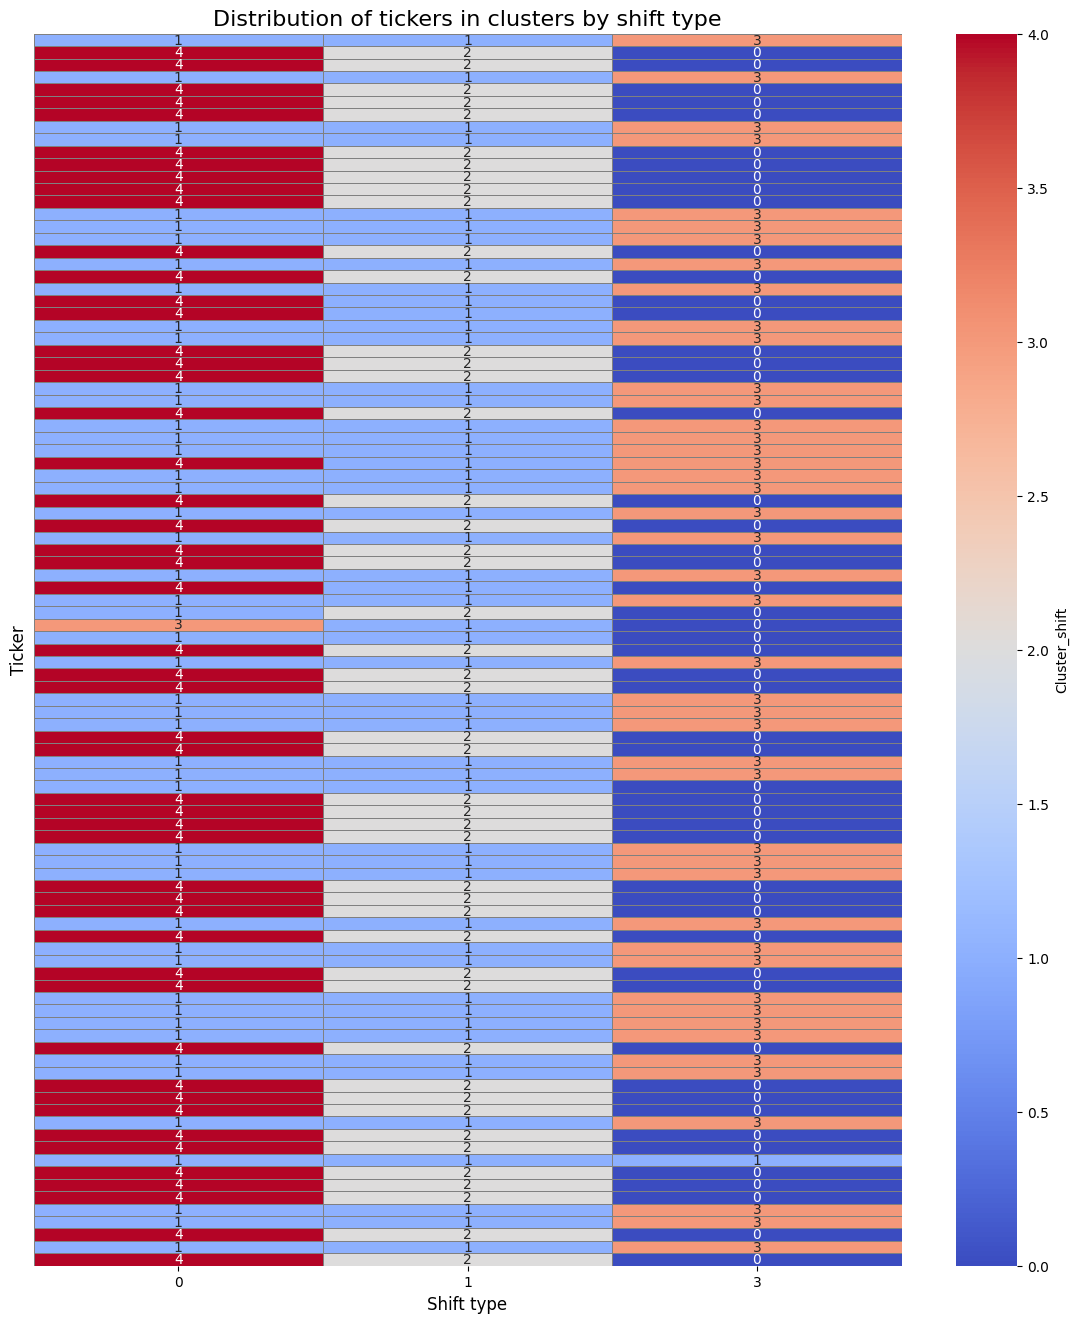

<Figure size 1000x800 with 0 Axes>

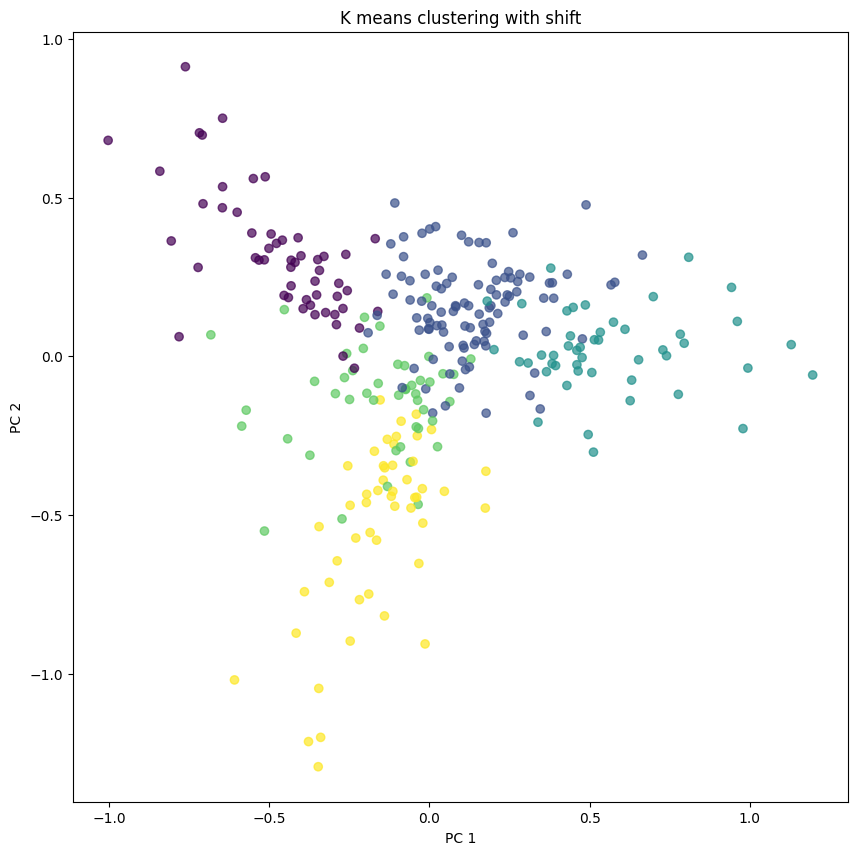

Silhouette score: 0.14622254627602313
Homogeneity: 0.26425509843189476
Completeness: 0.2713171255407458
V-Measure: 0.26773955222775375


In [ ]:

#Query to get the data from the database with the shift
query = """
SELECT *
FROM stock_return
"""
shift_df = pd.read_sql_query(query, conn)
cursor.close()
conn.close()
print(shift_df.columns)
# Normalize the numeric data
shift_data = shift_df.iloc[:, 5:]
scaler = MinMaxScaler()
shift_data_scaled = scaler.fit_transform(shift_data)

# KMeans clustering
number_of_clusters = 5
kmeans_shift = KMeans(n_clusters= number_of_clusters)
kmeans_shift.fit(shift_data_scaled)
shift_df['Cluster_shift'] = kmeans_shift.labels_


# Analize the clusters base on the shift type
ticker_shift_cluster_table = shift_df.groupby(['ticker', 'shift_type', 'Cluster_shift']).size().reset_index(name='Count')
# Visualize the distribution of clusters for each ticker and shift type with a heatmap
pivot_table_ticker_shift = ticker_shift_cluster_table.pivot(index='ticker', columns='shift_type', values='Cluster_shift').fillna(-1)
plt.figure(figsize=(14, 16))  
sns.heatmap(
    pivot_table_ticker_shift, 
    annot=True, 
    fmt='.0f', 
    cmap='coolwarm', 
    cbar_kws={'label': 'Cluster_shift'}, 
    linewidths=0.5, 
    linecolor='gray',
    yticklabels=False  # Remove ticker names from the y-axis
)
plt.title('Distribution of tickers in clusters by shift type', fontsize=16)
plt.xlabel('Shift type', fontsize=12)
plt.ylabel('Ticker', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8, rotation=0)
plt.show()

plt.figure(figsize=(10, 8))


pca_2d = PCA(n_components=2)
shift_data_pca_3d = pca_2d.fit_transform(shift_data_scaled)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(
    shift_data_pca_3d[:, 0], 
    shift_data_pca_3d[:, 1], 
    c=shift_df['Cluster_shift'], 
    cmap='viridis', 
    alpha=0.7
)
plt.title("K means clustering with shift")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

# Confusion matrix for clustering with shift
# Map sector names to numeric labels for shift_df
sector_to_numeric_shift = {sector: idx for idx, sector in enumerate(shift_df['sector'].unique())}
shift_df['sector_numeric'] = shift_df['sector'].map(sector_to_numeric_shift)

# Calculate the confusion matrix
conf_matrix_shift = confusion_matrix(shift_df["sector_numeric"], shift_df["Cluster_shift"])

# Calculate the silhouette score
silhouette_avg_shift = silhouette_score(shift_data_scaled, shift_df['Cluster_shift'])
print(f"Silhouette score: {silhouette_avg_shift}")

# Calculate homogeneity, completeness, and V-measure
homogeneity_shift, completeness_shift, v_measure_shift = homogeneity_completeness_v_measure(shift_df['sector_numeric'], shift_df['Cluster_shift'])

print(f"Homogeneity: {homogeneity_shift}")
print(f"Completeness: {completeness_shift}")
print(f"V-Measure: {v_measure_shift}")